# <a>**`Gender`-`Race`-`Age`-Prediction_Project**

## <a>***Project Description***


The goal of the project is to predict the following from images of the faces provided  in the dataset:

i. **Age**: is an integer from 0 to 116

ii. **Gender**: is either 0 (male) or 1 (female)

iii. **Race**: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern), respectively.

2. Download the dataset from: 

3. Please make sure to randomly assign 15% of the training set as validation data for hyper-parameter tuning and another 15% as test data.

4. Use random seed '777' wherever needed (like taking out 15% data from training set as validation and test set) for reproducibility.

5. Important measures: MAE and MSE for age, Accuracy and F1-score for gender and  race. (bold ones are the most important)

**You need to Experiment with the following setups:**

1. [45 points] Try separate model to predict each, i.e., age, gender, and race. You need to perform hyper parameter calibration and fine tuning including different regularization techniques (like dropout, batch-normalization) and to report all  the findings/conclusions.

2. [10 points] Apply data augmentation techniques and see the difference.

3. [10 points] Apply transfer learning by using pre-trained models.

4. [10 points] Combining 2 and 3.
5. [20 points] Merging all output variable into one single model with multiple heads to the model.

6. [5 points] Have a mechanism in your code so that if I provide you input test 
images (new images), it can use them to predict the age, gender and race and 
show them as output.

**Extras [10 points]:**
1. [5 points] Show class activation maps.
2. [5 points] Other ideas that you may find interesting.

**[15 points] The best performing model on the hidden test set will get additional 5% for each type of prediction, i.e., age, gender, and race.**

**Note:**
- The project should satisfactorily cover the following aspects: error analysis and possible improvements, final results on the test set, and conclusions from the work.
- You can work on the project alone or as a maximum of two members. Please send your project member details ASAP by email.
- If you are interested in some other topic, please consult your instructor.
- If you are interested in a research project, please consult your instructor.
- Your work will be checked with appropriate plagiarism detection tools like 
iThenticate.
- You can format your paper as a report or a scientific paper
- All the documents (code and report) should be submitted in Jupyter notebooks OR Jupyter notebooks (code) + PDF document (report).

## <a>***Import The Necessary Libraries.***

In [ ]:
import cv2
import os
import glob
import math
import random
import os.path
import numpy as np 
import pandas as pd 
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.cm as cm
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D,LeakyReLU, Dense, InputLayer,Dropout, Activation, Flatten,Input, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50, InceptionV3, Xception, VGG19,ResNet101
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, plot_confusion_matrix
from IPython.display import Image, display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [ ]:
# Random Seed 
seed_constant = 777
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## <a>***Download the Data and Preprocessing it in DataFrame.***

### **Download Data and Creat the Dataframe of Images with Labels**

In [ ]:
# Download the data (zip File) from dropbox 
%%capture
!wget -O FaceDataset.zip https://www.dropbox.com/s/rwyjvjomtirrjih/FaceDataset.zip?dl=0
!unzip FaceDataset.zip

In [ ]:

def Get_dataArray(imgsPaths):
  """
  Function that get the paths of images 
  first: read the images and resize it to two sizes (64,224) ---> 64 for quicker training and 224 for good accuracy
  second: get the labels from the image title (age, gender, race)
  third: divide the arrays by 255 for normalization

  """
  imgsPixels_64, imgsPixels_224, imgsNames, age, gender, race=[], [], [], [], [], []

  for path in imgsPaths:
    img_path=path
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) ### 1
    img_64=cv2.resize(img,(64,64))           ######## 2
    img_224=cv2.resize(img,(224,224))        ### has been divided by 256

    data=path.split('/')[-1].split("_")
    try:
      age_   = int(data[0]) 
      gender_= int(data[1])
      race_  = int(data[2])
    except:
      continue                ######### Image doesn't follow the pattern

    imgsNames.append(img_path)
    imgsPixels_64.append(img_64)
    imgsPixels_224.append(img_224)
    age.append(age_) 
    gender.append(gender_)
    race.append(race_)

  imgsNamesA      = np.array(imgsNames)
  imgsPixelsA_64  = np.array(imgsPixels_64)/255
  imgsPixelsA_224 = np.array(imgsPixels_224)/255
  ageA            = np.array(age)
  genderA         = np.array(gender)
  raceA           = np.array(race)

  return imgsNamesA, imgsPixelsA_64, imgsPixelsA_224, ageA, genderA, raceA

In [ ]:
# Read the images path and get its paths with Glob Library
imgsDir   ='/content/FaceDataset/images/'
imgsPaths = glob.glob(imgsDir+ "*.jpg")

In [ ]:
# Return the arrays from our function
imgsNames_, imgsPixels_64, imgsPixels_224,  Age_,Gender_,Race_ = Get_dataArray(imgsPaths)

In [ ]:
imgsPixels_224.shape

(9778, 224, 224, 3)

In [ ]:
# Check the shape
Gender_.shape

(9778,)

In [ ]:
# Reshape the arrays to be 1D vector
ageA    = np.reshape(Age_,(-1,1))
genderA = np.reshape(Gender_,(-1,1))
raceA   = np.reshape(Race_,(-1,1))

In [ ]:
# Recheck again
genderA.shape

(9778, 1)

In [ ]:
# Stacking the vectors to get y which conclud all our dependent variables
y=np.hstack((ageA,genderA))
y=np.hstack((y,raceA))
y.shape

(9778, 3)

### **Split Data into Train, Div, Test**

In [ ]:
# get the Indices in the range of our dataset as nummpy array
dataInds=np.arange(len(ageA))

In [ ]:
# split the indices to train, validation and test (As Recommended)
train_idx, ValTestidx = train_test_split(dataInds,   test_size=0.30, random_state=777)
val_idx,   test_idx   = train_test_split(ValTestidx, test_size=0.50, random_state=777) 

In [ ]:
# Check the shape
print(y.shape)
y[:5]

(9778, 3)


array([[49,  1,  3],
       [ 3,  1,  2],
       [12,  0,  4],
       [26,  0,  1],
       [30,  1,  3]])

In [ ]:
# Check
print(train_idx[:3])
print(val_idx[:3])
print(test_idx[:3])

[8383 7278 8272]
[5100  198 8198]
[7652 3784  799]


In [ ]:
# Create Dictionaries to map the labels and values
gender_values_to_labels = {0: 'male', 1: 'female'}
gender_labels_to_values = {'male': 0,'female': 1}
race_values_to_labels   = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
race_labels_to_values   = {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4 }
age_values_to_labels    = {0:'1-2', 1:'3-8', 2:'9-17', 3:'18-30', 4:'31-49', 5:'50-70', 6:'71-116'}

age_labels_to_values    = {'1-2':0, '3-8':1, '9-17':2, '18-30':3, '31-49':4, '50-70':5, '71-116':6}

gender_values_to_labels, gender_labels_to_values, race_values_to_labels, race_labels_to_values,age_values_to_labels,age_labels_to_values

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0},
 {0: '1-2',
  1: '3-8',
  2: '9-17',
  3: '18-30',
  4: '31-49',
  5: '50-70',
  6: '71-116'},
 {'1-2': 0,
  '18-30': 3,
  '3-8': 1,
  '31-49': 4,
  '50-70': 5,
  '71-116': 6,
  '9-17': 2})

### **Plot Examples from the Data**

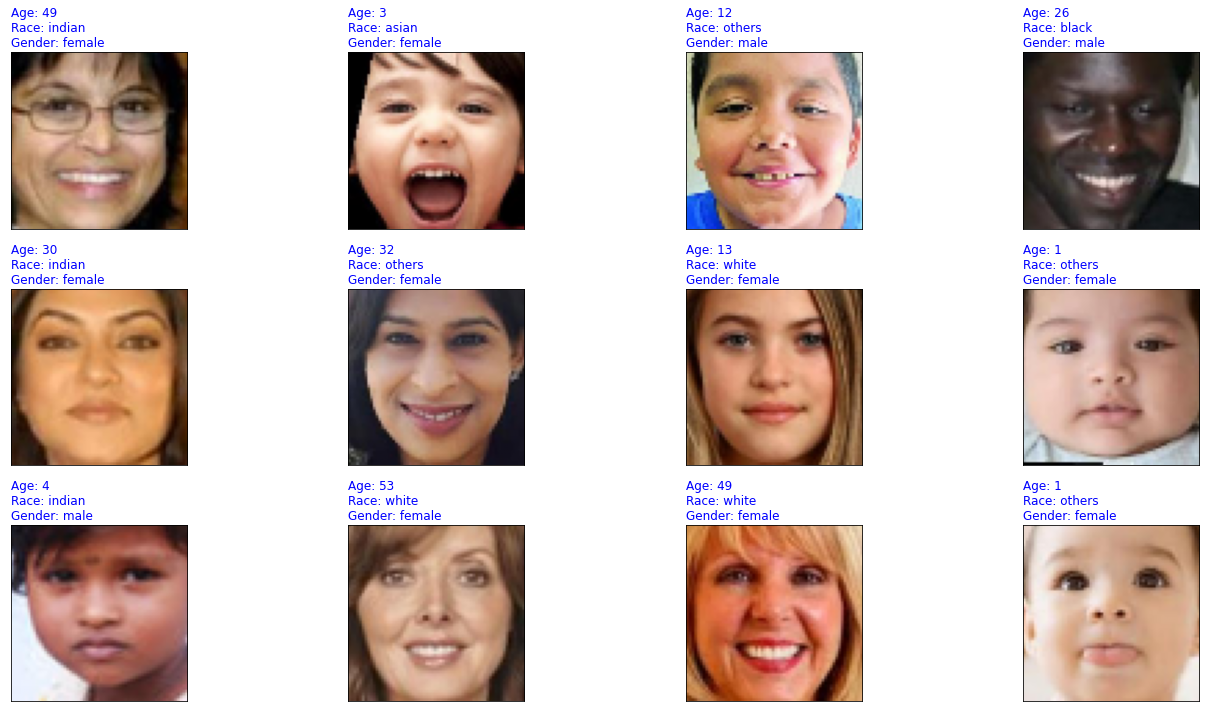

In [ ]:
# Display 12 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(imgsPixels_64[i])
  ax.set_title(f"Age: {Age_[i]}\nRace: {race_values_to_labels[Race_[i]]}\nGender: {gender_values_to_labels[Gender_[i]]}",loc="left",color='blue',fontsize = 12)
plt.tight_layout()
plt.show();

## <a>**Create Data Generator**

In [ ]:
def getDataGenerator(imgsPixels,inds,y,batch_size=32):
  """
  Generate the data as Batches
  """

    while True:
        rnd_inds=np.random.randint(0,len(inds),batch_size)

        imgs=imgsPixels[rnd_inds]

        Pixels=[img for img in imgs]

        yArray=y[rnd_inds]

        age_    = yArray[:,0]
        gender_ = yArray[:,1]
        race_   = yArray[:,2]
        
        gender_ = to_categorical(gender_,2)
        race_   = to_categorical(race_,5)
        
        yield np.array(Pixels), [np.array(age_), np.array(gender_), np.array(race_)]

## <a>**ResNet50**


##### <a>***CNN Model Network***

In [ ]:
ResNet50Model = ResNet50(weights='imagenet',include_top=False)

In [ ]:
# i.e. freeze all convolutional ResNet layers
for layer in ResNet50Model.layers:
    layer.trainable = False

In [ ]:
model_name="Combined_Model_Transfer_Learning_ResNet50_model"

X = ResNet50Model.output
X = GlobalAveragePooling2D()(X)
x = Flatten()(X)

# Age Calculation

age_ = Dense(units=256, activation='relu')(X)
age_ = BatchNormalization()(age_)
age_ = Dropout(0.2)(age_)
age_ = Dense(units=128, activation='relu')(age_)
age_ = BatchNormalization()(age_)
age_ = Dropout(0.2)(age_)
age  = Dense(units=1, activation='linear', name='age')(age_)


# Gender Prediction

gender_ = Dense(units=256, activation='relu')(X)
gender_ = BatchNormalization()(gender_)
gender_ = Dropout(0.2)(gender_)
gender_ = Dense(units=128, activation='relu')(gender_)
gender_ = BatchNormalization()(gender_)
gender_ = Dropout(0.2)(gender_)
gender  = Dense(units=2, activation='softmax', name='gender')(gender_)

# Race Prediction
race_ = Dense(units=256, activation='relu')(X)
race_ = BatchNormalization()(race_)
race_ = Dropout(0.2)(race_)
race_ = Dense(units=128, activation='relu')(race_)
race_ = BatchNormalization()(race_)
race_ = Dropout(0.2)(race_)
race  = Dense(units=5, activation='softmax', name='race')(race_)

Model_Combined3 = Model(inputs=ResNet50Model.input, outputs=[age, gender, race])


Model_Combined3.summary()



Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_18[0][0]']               
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

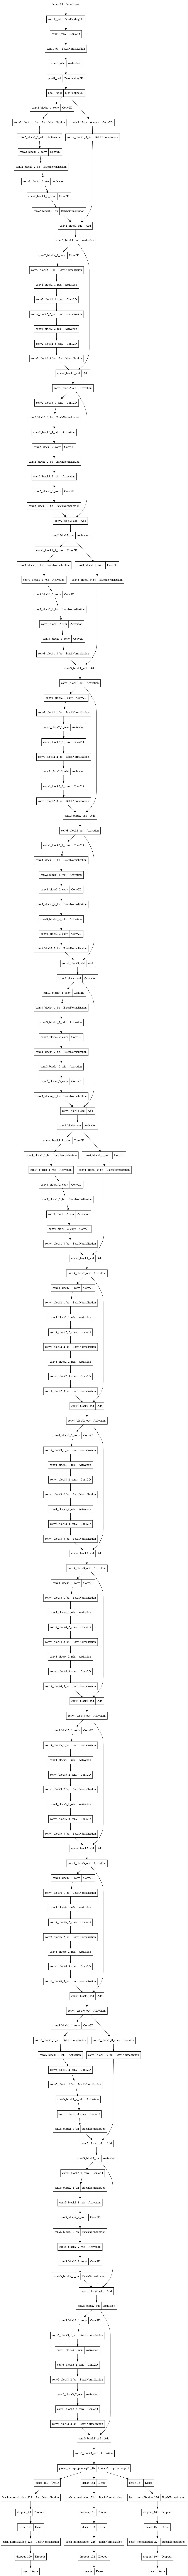

In [ ]:
plot_model(Model_Combined3,'model.jpg')

##### <a>***CNN Training***

In [ ]:
optimizer = Adam(0.0001)

Model_Combined3.compile(optimizer=optimizer, 
                        loss={'age': 'mae','gender': 'binary_crossentropy','race': 'categorical_crossentropy'},
                        metrics={'age': 'mae', 'gender': 'accuracy','race': 'accuracy'})

In [ ]:
checkpoint = ModelCheckpoint('models/'+model_name+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=7,restore_best_weights=True)

In [ ]:
epochs = 30
batch_size = 32
train_gen = getDataGenerator(imgsPixels_224, train_idx,y,batch_size)
valid_gen = getDataGenerator(imgsPixels_224, val_idx,  y,batch_size)

history = Model_Combined3.fit(train_gen,steps_per_epoch=len(train_idx)//batch_size, epochs=epochs, callbacks=[checkpoint,early_stop],
                              validation_data=valid_gen, validation_steps=len(val_idx)//batch_size)

Epoch 1/30
213/213 [==============================] - ETA: 0s - loss: 31.2907 - age_loss: 29.1902 - gender_loss: 0.5359 - race_loss: 1.5645 - age_mae: 29.1902 - gender_accuracy: 0.7641 - race_accuracy: 0.4356
Epoch 1: val_loss improved from inf to 28.40142, saving model to models/Combined_Model_Transfer_Learning_ResNet50_model.h5
213/213 [==============================] - 27s 91ms/step - loss: 31.2907 - age_loss: 29.1902 - gender_loss: 0.5359 - race_loss: 1.5645 - age_mae: 29.1902 - gender_accuracy: 0.7641 - race_accuracy: 0.4356 - val_loss: 28.4014 - val_age_loss: 26.9406 - val_gender_loss: 0.3982 - val_race_loss: 1.0627 - val_age_mae: 26.9406 - val_gender_accuracy: 0.8368 - val_race_accuracy: 0.6069
Epoch 2/30
213/213 [==============================] - ETA: 0s - loss: 31.4643 - age_loss: 29.8282 - gender_loss: 0.4365 - race_loss: 1.1995 - age_mae: 29.8282 - gender_accuracy: 0.8102 - race_accuracy: 0.5748
Epoch 2: val_loss did not improve from 28.40142
213/213 [=======================

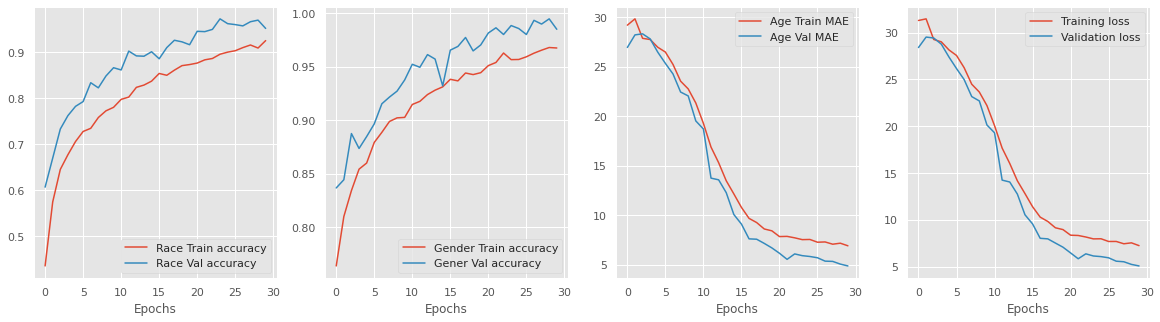

In [ ]:
plt.style.use("ggplot")
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].plot(history.history['race_accuracy'], label='Race Train accuracy')
axes[0].plot(history.history['val_race_accuracy'], label='Race Val accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend()

axes[1].plot(history.history['gender_accuracy'], label='Gender Train accuracy')
axes[1].plot(history.history['val_gender_accuracy'], label='Gener Val accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend()

axes[2].plot(history.history['age_loss'], label='Age Train MAE')
axes[2].plot(history.history['val_age_loss'], label='Age Val MAE')
axes[2].set_xlabel('Epochs')
axes[2].legend()  

axes[3].plot(history.history['loss'], label='Training loss')
axes[3].plot(history.history['val_loss'], label='Validation loss')
axes[3].set_xlabel('Epochs')
axes[3].legend()

##### <a>***Evaluation on Test***

In [ ]:
test_gen = getDataGenerator(imgsPixels_224, test_idx,  y,batch_size)

modelData_val  = dict(zip(Model_Combined3.metrics_names, Model_Combined3.evaluate(test_gen, steps=len(val_idx)//batch_size)))
modelData_Test = dict(zip(Model_Combined3.metrics_names, Model_Combined3.evaluate(valid_gen, steps=len(test_idx)//batch_size)))
print("")
print("*"*7)
print("Gender")
print("*"*7)
print('Validation Accuracy: ', round((modelData_val["gender_accuracy"] * 100)), "%")
print('Test Accuracy: ', round((modelData_Test["gender_accuracy"] * 100)), "%")
print("")
print('Validation Loss: ', round(modelData_val["gender_loss"], 1))
print('Test Loss: ', round(modelData_Test["gender_loss"], 1))

print("-"*30)
print("-"*30)

print("*"*7)
print("Race")
print("*"*7)
print('Validation Accuracy: ', round((modelData_val["race_accuracy"] * 100)), "%")
print('Test Accuracy: ', round((modelData_Test["race_accuracy"] * 100)), "%")
print("")
print('Validation Loss: ', round(modelData_val["race_loss"], 1))
print('Test Loss: ', round(modelData_Test["race_loss"], 1))

print("-"*30)
print("-"*30)

print("*"*7)
print("Age")
print("*"*7)
print('Validation Mean Absolute Error: ', round((modelData_val["age_mae"]),4))
print('Test Mean Absolute Error: ', round((modelData_Test["age_mae"]),4))


45/45 [==============================] - 3s 63ms/step - loss: 4.8989 - age_loss: 4.7148 - gender_loss: 0.0478 - race_loss: 0.1363 - age_mae: 4.7148 - gender_accuracy: 0.9847 - race_accuracy: 0.9528

*******
Gender
*******
Validation Accuracy:  98 %
Test Accuracy:  98 %

Validation Loss:  0.1
Test Loss:  0.0
------------------------------
------------------------------
*******
Race
*******
Validation Accuracy:  94 %
Test Accuracy:  95 %

Validation Loss:  0.2
Test Loss:  0.1
------------------------------
------------------------------
*******
Age
*******
Validation Mean Absolute Error:  5.1602
Test Mean Absolute Error:  4.7148


##### <a>***Save Keras Model to Drive***

In [ ]:
# %cp -r /content/models/Combined_Model_Transfer_Learning_ResNet50_model.h5 /content/drive/MyDrive/Gender-Age-Race_Prediction

##### <a>***`Confusion Matrix` and `Classification Report`***

In [ ]:
X_test = imgsPixels_224[test_idx]
y_test = y[test_idx]
print(X_test.shape)
print(y_test.shape)

(1467, 224, 224, 3)
(1467, 3)


###### **Predict on X_test**

In [ ]:
y_pred_age,y_pred_gender, y_pred_race =Model_Combined3.predict(X_test)

y_pred_gender = np.argmax(y_pred_gender,axis=1)
y_pred_race   = np.argmax(y_pred_race,axis=1)

y_true_age    = y_test[:,0]
y_true_gender = y_test[:,1]
y_true_race   = y_test[:,2]


###### **Confusion Matrix**

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
def confusionMatrixPlot(y_true,y_pred,Category):
  confusionMatrix = confusion_matrix(y_true,y_pred )

  ax = sns.heatmap(confusionMatrix, annot=True, cmap='Blues',fmt='g')

  ax.set_title(f'Confusion Matrix with labels for {Category}\n\n');
  ax.set_xlabel(f'\nPredicted {Category} Category')
  ax.set_ylabel(f'Actual {Category} Category ');

  ## Display the visualization of the Confusion Matrix.
  plt.show()

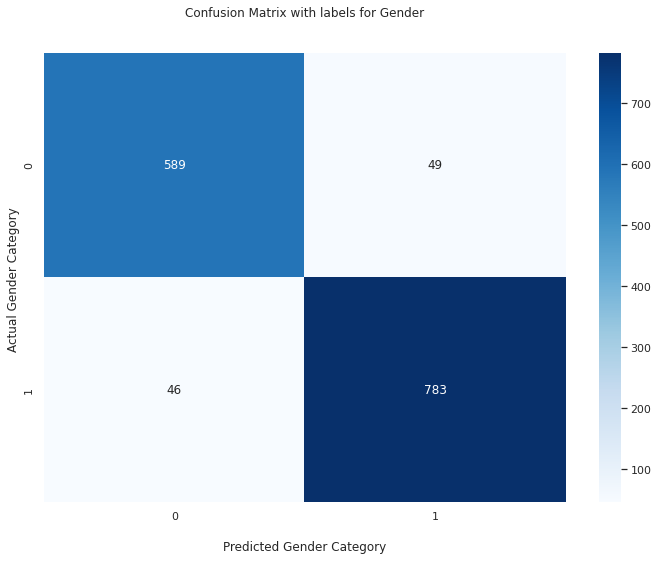

In [ ]:
confusionMatrixPlot(y_true_gender,y_pred_gender,"Gender")

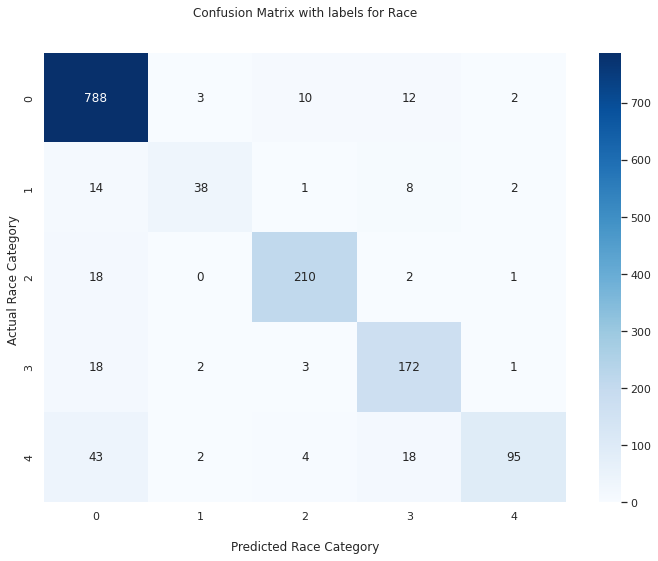

In [ ]:
confusionMatrixPlot(y_true_race,y_pred_race,"Race")

###### **R2 Score and Classification Report**

In [ ]:
print("*"*7)
print("Age")
print("*"*7)
R2_age = r2_score(y_true_age, y_pred_age, multioutput='variance_weighted')
print("Age R2:  ", round(R2_age,2))
print("Age MAE: ", round(mean_absolute_error(y_true_age,y_pred_age),2))
print("Age MSE: ", round(mean_squared_error(y_true_age,y_pred_age),2))
print("")
print("*"*7)
print("Gender")
print("*"*7)
print(classification_report(y_true_gender,y_pred_gender,zero_division=0))
print("*"*7)
print("Race")
print("*"*7)
print(classification_report(y_true_race,y_pred_race,zero_division=0))

*******
Age
*******
Age R2:   0.88
Age MAE:  5.55
Age MSE:  69.68

*******
Gender
*******
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       638
           1       0.94      0.94      0.94       829

    accuracy                           0.94      1467
   macro avg       0.93      0.93      0.93      1467
weighted avg       0.94      0.94      0.94      1467

*******
Race
*******
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       815
           1       0.84      0.60      0.70        63
           2       0.92      0.91      0.92       231
           3       0.81      0.88      0.84       196
           4       0.94      0.59      0.72       162

    accuracy                           0.89      1467
   macro avg       0.88      0.79      0.82      1467
weighted avg       0.89      0.89      0.88      1467



###### ***Window Difference Between True and Predicted on Test Ages***

In [ ]:
y_predList=y_pred_age.tolist()
y_testList=y_true_age.tolist()

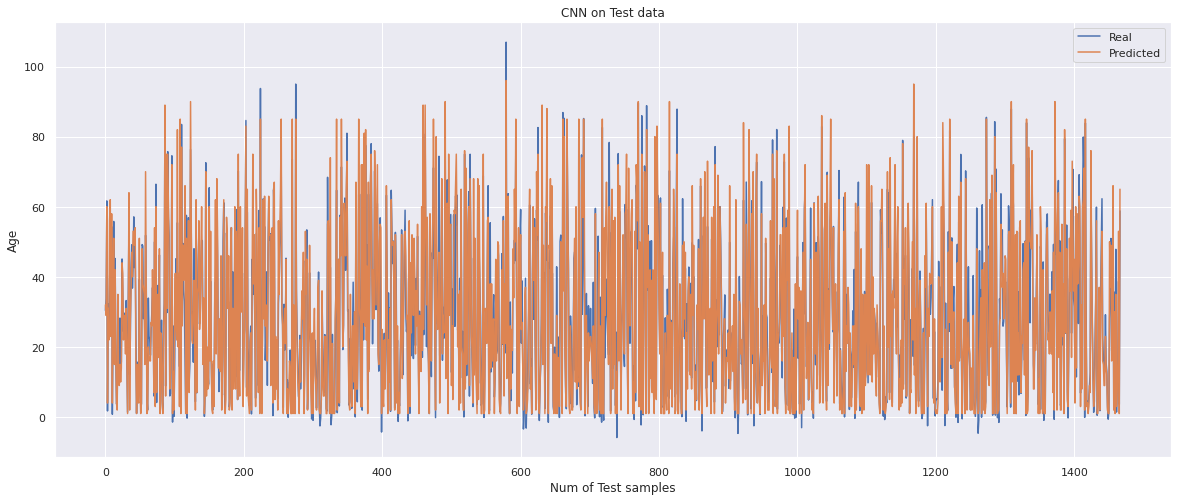

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(y_predList)
plt.plot(y_testList)
plt.legend(['Real', 'Predicted'])
plt.title("CNN on Test data")
plt.xlabel("Num of Test samples")
plt.ylabel("Age")
plt.show()

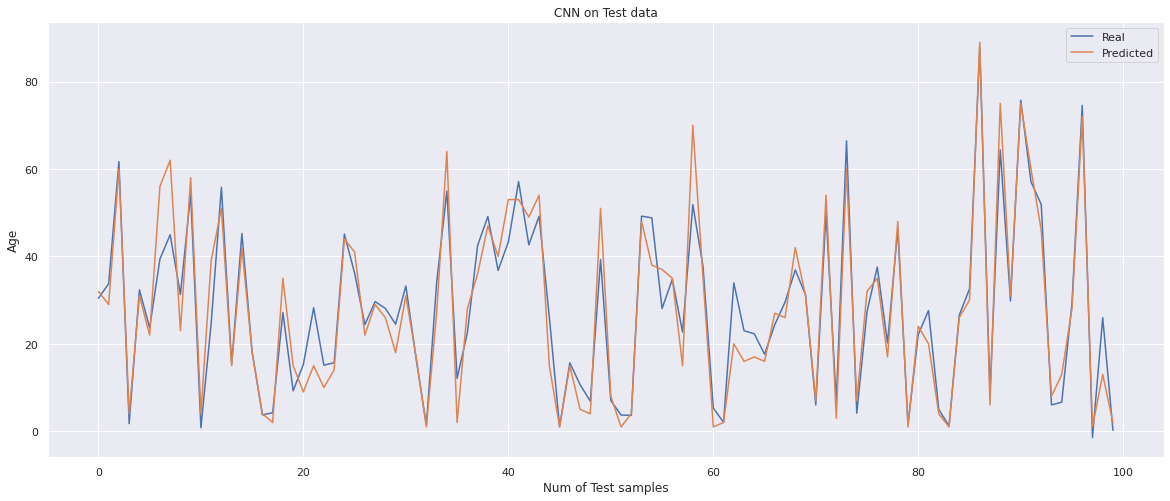

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(y_predList[:100])
plt.plot(y_testList[:100])
plt.legend(['Real', 'Predicted'])
plt.title("CNN on Test data")
plt.xlabel("Num of Test samples")
plt.ylabel("Age")
plt.show()

##### <a>***Display Images from the Test Dataset***

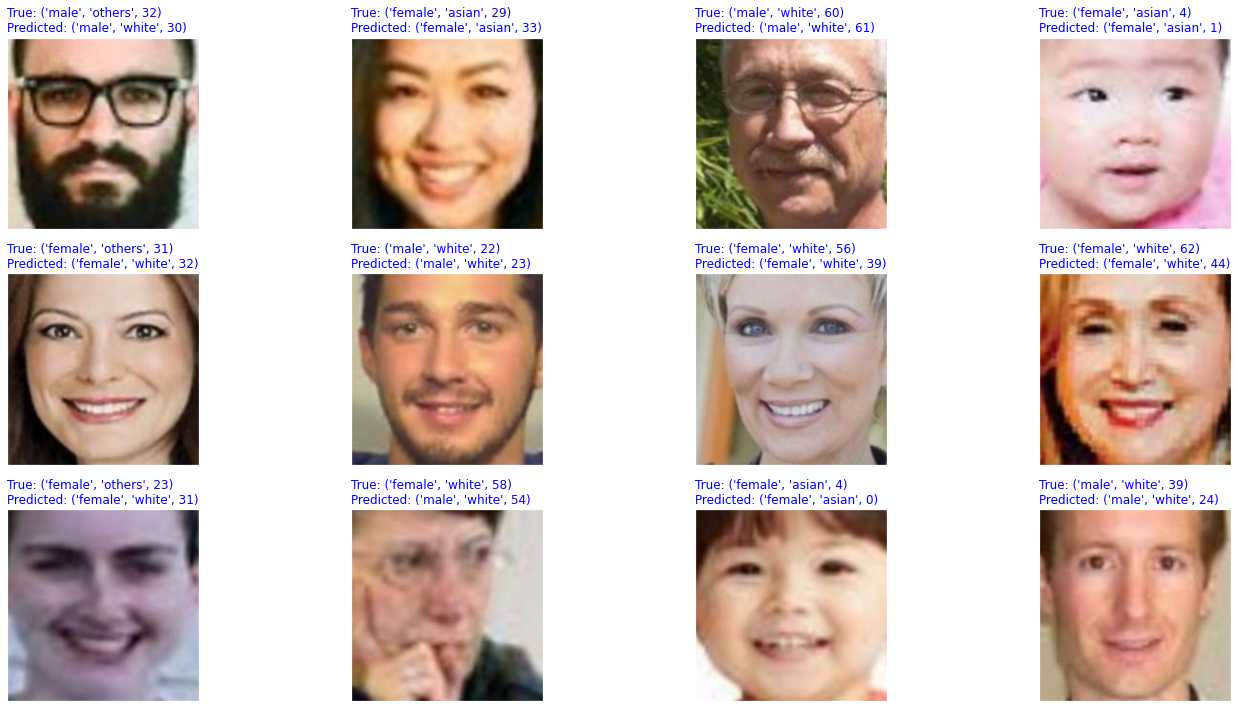

In [ ]:
# Display 12 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  ax.imshow(X_test[i])
  ax.set_title(f"True: {gender_values_to_labels[y_true_gender[i]],race_values_to_labels[y_true_race[i]], y_true_age[i]}\nPredicted: {gender_values_to_labels[y_pred_gender[i]],race_values_to_labels[y_pred_race[i]],int(y_pred_age[i][0])}",loc="left",color='blue',fontsize = 12)
plt.tight_layout()
plt.show();



---



---



---



## <a>***Predict Age, Gender and Race on (New Images) and Show Them as Output.***

---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
gender_values_to_labels = {0: 'male', 1: 'female'}
race_values_to_labels   = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Gender-Age-Race_Prediction_Project/Final/Combined_Model_Transfer_Learning_ResNet50_model.h5')

In [ ]:
def Predict_Test_Image(imgPath,model):
  imgsPixels_=[]
  img=cv2.imread(imgPath)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))
  imgsPixels_.append(img)
  imgsPixelsA_ = np.array(imgsPixels_)

  y_pred_age,y_pred_gender, y_pred_race =model.predict(imgsPixelsA_)
  
  y_pred_gender = np.argmax(y_pred_gender,axis=1)
  y_pred_race   = np.argmax(y_pred_race,axis=1)

  Gender = gender_values_to_labels[y_pred_gender[0]]
  Race   = race_values_to_labels[y_pred_race[0]]
  Age    = int(y_pred_age[0][0])

  fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),subplot_kw={'xticks': [], 'yticks': []})
  axes.imshow(imgsPixelsA_[0])
  axes.set_title(f"Predicted:\n***** \nGender: {Gender} \nRace: {Race} \nAge: {Age}",loc="left",color='blue',fontsize = 15)
  plt.tight_layout()
  plt.show();

  return Gender, Race, Age

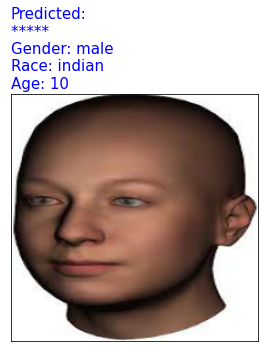

In [ ]:
Gender, Race, Age = Predict_Test_Image("/content/face1.jpg",model)

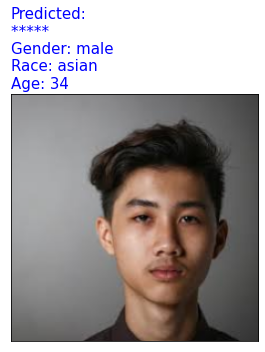

In [ ]:
Gender, Race, Age = Predict_Test_Image("/content/face2.jpg",model)

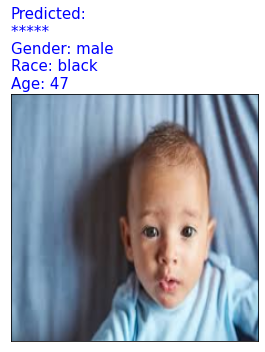

In [ ]:
Gender, Race, Age = Predict_Test_Image("/content/face3.jpg",model)

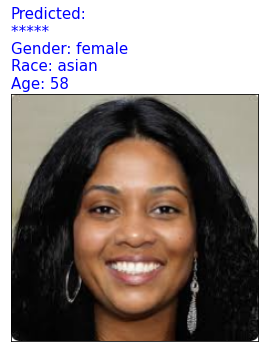

In [ ]:
Gender, Race, Age = Predict_Test_Image("/content/face4.jpg",model)

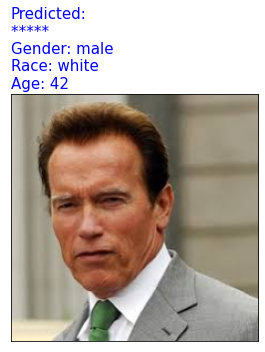

In [ ]:
Gender, Race, Age = Predict_Test_Image("/content/face5.jpg",model)

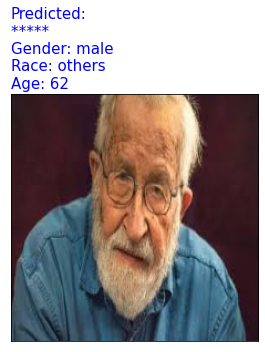

In [ ]:
Gender, Race, Age = Predict_Test_Image("/content/face6.jpg",model)



---

---



---





---

